In [1]:
import sqlite3
from typing import Annotated, Literal, Sequence, TypedDict

# LangChain core components
from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field

# LangGraph components
from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import tools_condition, ToolNode

# LangChain tools and retriever
from langchain.tools.retriever import create_retriever_tool

# LangChain community integrations
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma

# Text splitting utility
from langchain_text_splitters import RecursiveCharacterTextSplitter

c:\Users\DELL\SQL-Database-Agents-with-LangGraph\sql_env\lib\site-packages\IPython\core\interactiveshell.py:3579: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)
USER_AGENT environment variable not set, consider setting it to identify your requests.
USER_AGENT environment variable not set, consider setting it to identify your requests.


In [2]:
connection=sqlite3.connect("my_db.db")

In [3]:
connection

In [4]:
# Define all table creation queries FIRST
table_creation_query = """
CREATE TABLE IF NOT EXISTS USERS(
    emp_id INTEGER PRIMARY KEY,
    first_name TEXT NOT NULL,
    last_name TEXT NOT NULL,
    email TEXT NOT NULL,
    hire_date TEXT NOT NULL,
    salary REAL NOT NULL
);
"""

table_creation_query_departments = """
CREATE TABLE IF NOT EXISTS DEPARTMENTS (
    dept_id INTEGER PRIMARY KEY,
    dept_name TEXT NOT NULL UNIQUE
);
"""

table_creation_query_employees_departments = """
CREATE TABLE IF NOT EXISTS EMPLOYEES_DEPARTMENTS (
    emp_id INTEGER,
    dept_id INTEGER,
    PRIMARY KEY (emp_id, dept_id),
    FOREIGN KEY (emp_id) REFERENCES USERS(emp_id),
    FOREIGN KEY (dept_id) REFERENCES DEPARTMENTS(dept_id)
);
"""

table_creation_query_projects = """
CREATE TABLE IF NOT EXISTS PROJECTS (
    project_id INTEGER PRIMARY KEY,
    project_name TEXT NOT NULL,
    start_date TEXT,
    end_date TEXT
);
"""

table_creation_query_assignments = """
CREATE TABLE IF NOT EXISTS ASSIGNMENTS (
    assignment_id INTEGER PRIMARY KEY,
    emp_id INTEGER,
    project_id INTEGER,
    assigned_date TEXT NOT NULL,
    role TEXT,
    FOREIGN KEY (emp_id) REFERENCES USERS(emp_id),
    FOREIGN KEY (project_id) REFERENCES PROJECTS(project_id)
);
"""

table_creation_query_attendance = """
CREATE TABLE IF NOT EXISTS ATTENDANCE (
    attendance_id INTEGER PRIMARY KEY,
    emp_id INTEGER,
    date TEXT NOT NULL,
    status TEXT NOT NULL CHECK(status IN ('Present', 'Absent', 'Leave')),
    FOREIGN KEY (emp_id) REFERENCES USERS(emp_id)
);
"""




In [5]:
# Now execute them
import sqlite3

conn = sqlite3.connect("company_emp-.db")
cursor = conn.cursor()

cursor.execute(table_creation_query)
cursor.execute(table_creation_query_departments)
cursor.execute(table_creation_query_employees_departments)
cursor.execute(table_creation_query_projects)
cursor.execute(table_creation_query_assignments)
cursor.execute(table_creation_query_attendance)



In [6]:
users_data = [
    (1, 'John', 'Doe', 'john.doe@example.com', '2022-01-10', 60000),
    (2, 'Jane', 'Smith', 'jane.smith@example.com', '2021-03-15', 65000),
    (3, 'Alice', 'Johnson', 'alice.johnson@example.com', '2020-07-20', 70000),
    (4, 'Bob', 'Brown', 'bob.brown@example.com', '2023-02-10', 55000),
    (5, 'Charlie', 'Davis', 'charlie.davis@example.com', '2022-08-05', 58000),
    (6, 'Diana', 'Evans', 'diana.evans@example.com', '2021-11-11', 62000),
    (7, 'Frank', 'Green', 'frank.green@example.com', '2022-05-01', 67000),
    (8, 'Grace', 'Hall', 'grace.hall@example.com', '2020-09-13', 69000),
    (9, 'Henry', 'Irwin', 'henry.irwin@example.com', '2019-12-23', 71000),
    (10, 'Ivy', 'James', 'ivy.james@example.com', '2023-04-14', 63000),
]


departments_data = [
    (1, 'HR'),
    (2, 'Engineering'),
    (3, 'Marketing'),
    (4, 'Finance'),
    (5, 'Sales')
]

employees_departments_data = [
    (1, 2),
    (2, 1),
    (3, 2),
    (4, 3),
    (5, 4),
    (6, 1),
    (7, 2),
    (8, 3),
    (9, 4),
    (10, 5)
]

projects_data = [
    (1, 'Project Apollo', '2023-01-01', '2023-12-31'),
    (2, 'Project Titan', '2022-06-01', '2023-06-01'),
    (3, 'Project Orion', '2023-03-01', '2023-10-01')
]

assignments_data = [
    (1, 1, 1, '2023-01-15', 'Developer'),
    (2, 2, 1, '2023-01-20', 'Manager'),
    (3, 3, 2, '2022-07-01', 'Developer'),
    (4, 4, 3, '2023-03-10', 'Tester'),
    (5, 5, 1, '2023-02-01', 'Analyst'),
    (6, 6, 2, '2022-09-15', 'Support'),
    (7, 7, 1, '2023-01-25', 'Developer'),
    (8, 8, 3, '2023-04-01', 'UI/UX Designer'),
    (9, 9, 2, '2022-10-10', 'QA'),
    (10, 10, 1, '2023-05-05', 'Consultant'),
]

attendance_data = [
    (1, 1, '2023-05-01', 'Present'),
    (2, 2, '2023-05-01', 'Absent'),
    (3, 3, '2023-05-01', 'Leave'),
    (4, 4, '2023-05-01', 'Present'),
    (5, 5, '2023-05-01', 'Present'),
    (6, 6, '2023-05-01', 'Absent'),
    (7, 7, '2023-05-01', 'Leave'),
    (8, 8, '2023-05-01', 'Present'),
    (9, 9, '2023-05-01', 'Present'),
    (10, 10, '2023-05-01', 'Absent'),
]


In [7]:
cursor.executemany("INSERT INTO USERS VALUES (?, ?, ?, ?, ?, ?);", users_data)
cursor.executemany("INSERT INTO DEPARTMENTS VALUES (?, ?);", departments_data)
cursor.executemany("INSERT INTO EMPLOYEES_DEPARTMENTS VALUES (?, ?);", employees_departments_data)
cursor.executemany("INSERT INTO PROJECTS VALUES (?, ?, ?, ?);", projects_data)
cursor.executemany("INSERT INTO ASSIGNMENTS VALUES (?, ?, ?, ?, ?);", assignments_data)
cursor.executemany("INSERT INTO ATTENDANCE VALUES (?, ?, ?, ?);", attendance_data)

In [8]:
from langchain_core.messages import ToolCall


In [9]:
conn.commit()
#conn.close()

In [10]:
cursor.execute("select * from USERS")

In [11]:
for row in cursor.fetchall():
    print(row)

(1, 'John', 'Doe', 'john.doe@example.com', '2022-01-10', 60000.0)
(2, 'Jane', 'Smith', 'jane.smith@example.com', '2021-03-15', 65000.0)
(3, 'Alice', 'Johnson', 'alice.johnson@example.com', '2020-07-20', 70000.0)
(4, 'Bob', 'Brown', 'bob.brown@example.com', '2023-02-10', 55000.0)
(5, 'Charlie', 'Davis', 'charlie.davis@example.com', '2022-08-05', 58000.0)
(6, 'Diana', 'Evans', 'diana.evans@example.com', '2021-11-11', 62000.0)
(7, 'Frank', 'Green', 'frank.green@example.com', '2022-05-01', 67000.0)
(8, 'Grace', 'Hall', 'grace.hall@example.com', '2020-09-13', 69000.0)
(9, 'Henry', 'Irwin', 'henry.irwin@example.com', '2019-12-23', 71000.0)
(10, 'Ivy', 'James', 'ivy.james@example.com', '2023-04-14', 63000.0)


In [12]:
from langchain_community.utilities import SQLDatabase

In [13]:
db = SQLDatabase.from_uri("sqlite:///company_emp_.db")

In [14]:
db

In [15]:
db.dialect

'sqlite'

In [16]:
db.get_usable_table_names()

[]

In [17]:
from langchain_groq import ChatGroq
llm = ChatGroq(model="llama3-70b-8192")


In [18]:
llm.invoke("how are you ?")

AIMessage(content="I'm just a language model, I don't have feelings or emotions like humans do, so I don't have good or bad days. However, I'm functioning properly and ready to assist you with any questions or tasks you may have!", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 49, 'prompt_tokens': 14, 'total_tokens': 63, 'completion_time': 0.150406806, 'prompt_time': 0.004383959, 'queue_time': 1.084588701, 'total_time': 0.154790765}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_2f30b0b571', 'finish_reason': 'stop', 'logprobs': None}, id='run--6325f850-6d36-4f72-89f7-e6e3f257bb16-0', usage_metadata={'input_tokens': 14, 'output_tokens': 49, 'total_tokens': 63})

In [19]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit

In [20]:
toolkit =SQLDatabaseToolkit(db=db,llm=llm)

In [21]:
tools =toolkit.get_tools()

In [22]:
for tool in tools:
    print(tool.name)

sql_db_query
sql_db_schema
sql_db_list_tables
sql_db_query_checker


In [23]:
list_table_tool=next((tool for tool in tools if tool.name=="sql_db_list_tables"),None)

In [24]:
get_schema_tool = next(tool for tool in tools if tool.name == "sql_db_schema")


In [25]:
list_table_tool

ListSQLDatabaseTool(db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x00000192FF88E530>)

In [26]:
list_table_tool.invoke("")

''

In [27]:
print(get_schema_tool.invoke("USERS"))

Error: table_names {'USERS'} not found in database


In [28]:
from langchain_core.tools import tool

@tool
def db_query_tool(query: str) -> str:
    """Execute a SQL query against the database and return results."""
    result = db.run_no_throw(query)
    if not result:
        return "Error: Query failed. Please rewrite your query and try again."
    return str(result)

In [29]:
db_query_tool.invoke("SELECT * FROM USERS;")

'Error: (sqlite3.OperationalError) no such table: USERS\n[SQL: SELECT * FROM USERS;]\n(Background on this error at: https://sqlalche.me/e/20/e3q8)'

In [32]:
from langchain_core.prompts import ChatMessagePromptTemplate

In [33]:
# SYSTEM PROMPT
query_check_system = """You are a SQL expert with a strong attention to detail.

Double check the SQLite query for common mistakes, including:

- Using NOT IN with NULL values
- Using UNION when UNION ALL should have been used
- Using BETWEEN for exclusive ranges
- Data type mismatch in predicates
- Properly quoting identifiers
- Using the correct number of arguments for functions
- Casting to the correct data type
- Using the proper columns for joins

If there are any of the above mistakes, rewrite the query. If there are no mistakes, just reproduce the original query.

You will call the appropriate tool to execute the query after running this check."""

# PROMPT TEMPLATE
from langchain_core.prompts import ChatPromptTemplate
query_check_prompt = ChatPromptTemplate.from_messages([
    ("system", query_check_system),
    ("user", "{messages}")
])

# CHAIN TO TOOL
query_check = query_check_prompt | llm.bind_tools([db_query_tool])






In [34]:
# INVOKE WITH INPUT
response = query_check.invoke({
    "messages": [("SELECT FROM Employees LIMIT 5;")]
})

In [35]:
response

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_pgtb', 'function': {'arguments': '{"query":"SELECT ID, Name, Department FROM Employees LIMIT 5;"}', 'name': 'db_query_tool'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 191, 'prompt_tokens': 1018, 'total_tokens': 1209, 'completion_time': 0.545714286, 'prompt_time': 0.042574803, 'queue_time': 0.054757378, 'total_time': 0.588289089}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_dd4ae1c591', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--f4e95459-503b-4bf6-8d85-6794ff9ad5c7-0', tool_calls=[{'name': 'db_query_tool', 'args': {'query': 'SELECT ID, Name, Department FROM Employees LIMIT 5;'}, 'id': 'call_pgtb', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1018, 'output_tokens': 191, 'total_tokens': 1209})

In [36]:

from pydantic import BaseModel, Field
# 1. Define the Pydantic model for the final answer
class SubmitFinalAnswer(BaseModel):
    """Submit the final answer to the user based on the query results."""
    final_answer: str = Field(..., description="The final answer to the user")

# 2. Define the system prompt for query generation
query_gen_system = """
You are a SQL expert with a strong attention to detail.

Given an input question, output a syntactically correct SQLite query to run.

DO NOT call any tool besides SubmitFinalAnswer to submit the final answer.

When generating the query:

- Output the SQL query that answers the input question without a tool call.
- Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most 10 rows.
- You can order the results by a relevant column to return the most interesting examples.
- Do not select all columns (*), only the relevant columns given the question.
- If you get an error while executing a query, rewrite the query and try again.
- If you get an empty result set, try to rewrite the query to get a non-empty result set.
- NEVER make stuff up if you don't have enough information to answer the query; just say you don't have enough information.
- If you have enough information to answer the input question, invoke SubmitFinalAnswer tool with the final answer.
- DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP, etc.) to the database.
- Do not return any SQL query except the answer when submitting the final answer.
"""

# 3. Create prompt template with system + placeholder for user messages
query_gen_prompt = ChatPromptTemplate.from_messages([
    ("system", query_gen_system),
    ("user", "{messages}")
])

# 4. Define SubmitFinalAnswer tool using the Pydantic model (you can add functionality here if needed)
@tool
def submit_final_answer(final_answer: str) -> str:
    """Tool to submit the final answer to the user."""
    # Here you can add any final processing, logging, etc.
    return final_answer

# 5. Bind the prompt and tool with your LLM (make sure llm is defined, e.g., ChatGroq)
query_gen_chain = query_gen_prompt | llm.bind_tools([submit_final_answer])


In [37]:
from typing import Annotated, TypedDict, List
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[List[BaseMessage], add_messages]


In [38]:
from langchain_core.messages import AIMessage
from langchain_core.pydantic_v1 import BaseModel, Field
from typing_extensions import TypedDict

In [39]:
def first_tool_call(state: State) -> State:
    tool_call = ToolCall(
        name="sql_db_list_tables",
        args={},
        id="tool_abcd123"
    )

    ai_message = AIMessage(
        content="Calling sql_db_list_tables to get list of tables.",
        tool_calls=[tool_call]
    )

    return {
        "messages": state["messages"] + [ai_message]
    }

In [40]:
def handle_tool_error(state: State) -> State:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls  # Get tool calls from last AIMessage

    return {
        "messages": state["messages"] + [
            ToolMessage(
                content=f"Error: {repr(error)}\nPlease fix your mistakes.",
                tool_call_id=tc["id"],
            ) for tc in tool_calls
        ]
    }

In [41]:
from langchain_core.messages import ToolMessage
from langgraph.prebuilt import ToolNode
from langchain_core.runnables import RunnableWithFallbacks, RunnableLambda
from typing import Any, List


In [42]:
def create_tool_node_with_fallback(tools: List[Any]) -> RunnableWithFallbacks[Any, dict]:
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)],
        exception_key="error"
    )

In [43]:
def model_check_query(state: State) -> State:
    # Invoke the query checker model with the last message
    result = query_check.invoke({"messages": [state["messages"][-1]]})
    
    return {
        "messages": state["messages"] + [result]
    }


In [44]:
def query_gen_nood(state: State):
    message = query_gen.invoke(state)

    tool_messages = []

    if getattr(message, "tool_calls", None):
        for tc in message.tool_calls:
            if tc["name"] != "SubmitFinalAnswer":
                tool_messages.append(
                    ToolMessage(
                        content=f"Error: The wrong tool was called: {tc['name']}. Please fix your mistakes. Remember to only call SubmitFinalAnswer.",
                        tool_call_id=tc["id"],
                    )
                )

    return {
        "messages": state["messages"] + [message] + tool_messages
    }

In [45]:
def should_continue(state: State) -> Literal["__end__", "correct_query", "query_gen"]:
    messages = state["messages"]
    last_message = messages[-1]

    if getattr(last_message, "tool_calls", None):
        return END

    if last_message.content and last_message.content.startswith("Error:"):
        return "query_gen"
    
    return "correct_query"

In [46]:
workflow = StateGraph(State)


In [47]:
model_get_schema = llm.bind_tools([get_schema_tool])


In [48]:
# Add nodes for the first two tools
workflow.add_node(
    "list_tables_tool", create_tool_node_with_fallback([list_table_tool])
)
#workflow.add_node("get_schema_tool", create_tool_node_with_fallback([get_schema_tool]))

# Add a node for a model to choose the relevant tables based on the question and available tables
model_get_schema = llm.bind_tools(
    [get_schema_tool]
)
workflow.add_node(
    "model_get_schema",
    lambda state: {
        "messages": [model_get_schema.invoke(state["messages"])],
    },
)

In [53]:
workflow.add_node("get_schema_tool", create_tool_node_with_fallback([get_schema_tool]))


In [49]:
workflow.add_node("query_gen", query_gen_nood)

# Add a node for the model to check the query before executing it
workflow.add_node("correct_query", model_check_query)

# Add node for executing the query
workflow.add_node("execute_query", create_tool_node_with_fallback([db_query_tool]))



In [50]:
# Specify the edges between the nodes
workflow.add_edge(START, "first_tool_call")
workflow.add_edge("first_tool_call", "list_tables_tool")
workflow.add_edge("list_tables_tool", "model_get_schema")
workflow.add_edge("model_get_schema", "get_schema_tool")
workflow.add_edge("get_schema_tool", "query_gen")
workflow.add_conditional_edges(
    "query_gen",
    should_continue,
)
workflow.add_edge("correct_query", "execute_query")
workflow.add_edge("execute_query", "query_gen")


In [51]:
workflow.add_node("first_tool_call", first_tool_call)



In [54]:
app=workflow.compile()

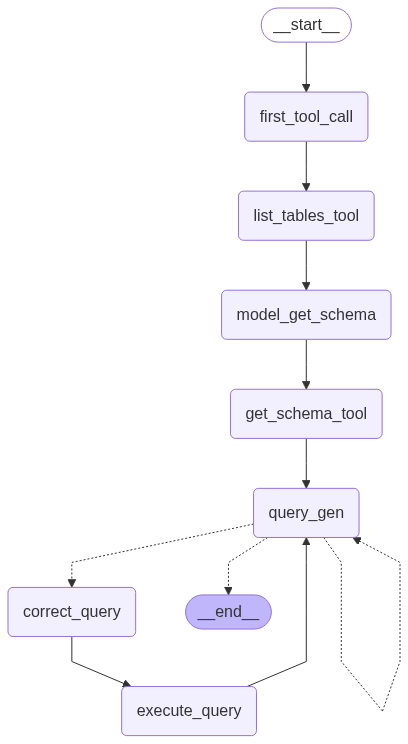

In [55]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)